In [3]:
from pathlib import Path

import pandas as pd

## Data

In [4]:
def read_results(file):
    """Extract a dictionary with the results from the file"""
    results = {}
    metrics_prefixes = ("recall", "ndcg")
    with open(file) as f:
        for line in f:
            if line.startswith(metrics_prefixes):
                parts = line.strip().split()
                metric = parts[0]
                value = float(parts[2])
                results[metric] = value
    return results

corpora = ["eswiki_20240401", "pres", "mmarco", "miracl", "sqac", "meup"]
dataset_names = ["messirve-v1.0-full-test", "pres", "mmarco", "miracl", "sqac", "meup"]
model_names = ["bm25", "multilingual-e5-large", "mdpr-tied-pft-msmarco-ft-miracl-es", "multilingual-e5-large-ft-full"]

results = {}
for corpus, dataset in zip(corpora, dataset_names):
    for model in model_names:
        file = f"../runs/evaluations/eval.{corpus}.{model}.{dataset}.tsv"
        results[(model, dataset)] = read_results(file)

In [5]:
df = pd.DataFrame(results)
df = df.T
df = df.reset_index()
df = df.rename(columns={"level_0": "model", "level_1": "dataset"})

# Specific order for the categories:
# dataset: order by N queries:
first_levels = ["messirve-v1.0-full-test", "miracl", "mmarco", "sqac", "meup", "pres"]
datasets = first_levels # + [c for c in sorted(df["country"].unique()) if c not in first_levels]
df["dataset"] = pd.Categorical(df["dataset"], datasets)
# Model: first "bm25", then the rest alphabetically:
models = ["bm25"] + [m for m in sorted(df["model"].unique()) if m != "bm25"] #+ ["XPLACEHOLDER"]
df["model"] = pd.Categorical(df["model"], models)

df = df.melt(id_vars=["model", "dataset"], var_name="metric", value_name="value")
df = df.sort_values(["model", "dataset", "metric"])
# df

## Plot

In [ ]:
dataset_names_dict = {
    "messirve-v1.0-full-test": "MessIRve",
    "pres": "PRES", #"PRES-test",
    "mmarco": "mMARCO", #"mMARCO-test",
    "sqac": "SQAC", #"SQAC-test",
    "meup": "Multi-EuP", #"Multi-EuP-test",
    "miracl": "MIRACL", #"MIRACL-dev",
}
# NOTE we use test set in all except MIRACL which is not public, we use dev.

model_names_dict = {
    "bm25": "BM25",
    "mdpr-tied-pft-msmarco-ft-miracl-es": "MIRACL-mdpr-es",
    "multilingual-e5-large": "E5-large",
    "multilingual-e5-large-ft-full": "E5-large-ft-messirve",
}

metric_names_dict = {
    "ndcg_cut_10": "nDCG@10",
    "recall_100": "Recall@100",
}

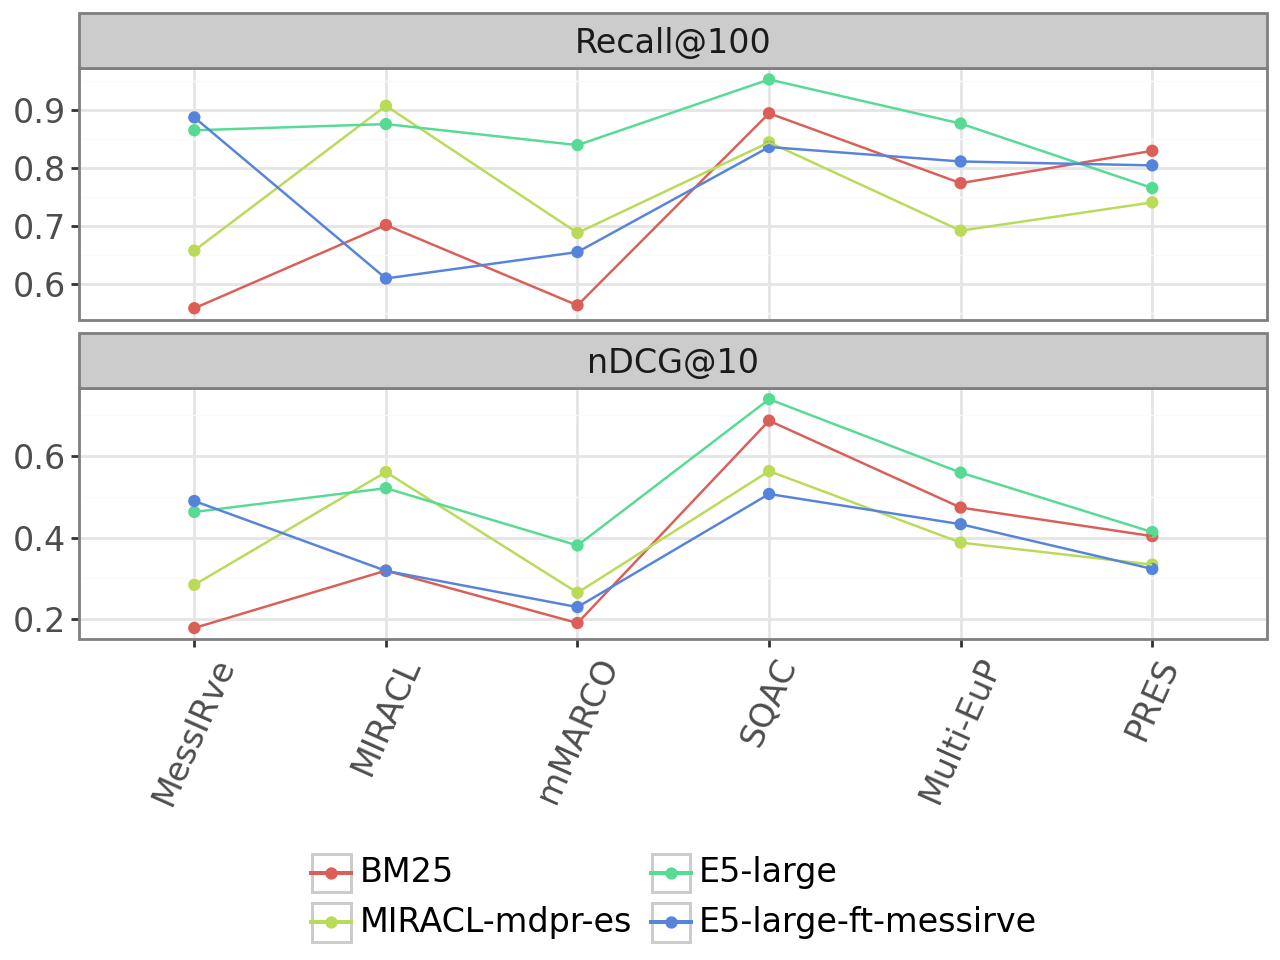

/home/fvalentini/miniconda3/envs/spanish-ir/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5.5 x 4.5 in image.
/home/fvalentini/miniconda3/envs/spanish-ir/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../runs/plots/other_datasets_results.pdf


In [7]:
from plotnine import (
    ggplot, aes, geom_point, geom_line, facet_wrap, theme, element_text,
    theme_bw, element_blank, guides, guide_legend, labs, scale_color_manual,
    scale_fill_hue
)

df_tmp = df.copy()
df_tmp["dataset"] = df_tmp["dataset"].map(dataset_names_dict)
df_tmp["metric"] = df_tmp["metric"].map(metric_names_dict)
df_tmp["model"] = df_tmp["model"].map(model_names_dict)

df_tmp["model"] = pd.Categorical(df_tmp["model"], list(model_names_dict.values()))


p = (
    ggplot(df_tmp, aes(x="dataset", y="value", color="model", group="model"))
    + geom_point()
    + geom_line()
    + facet_wrap("~metric", scales="free_y", ncol=1)
    + theme_bw()
    + labs(x="", y="")
    + guides(color=guide_legend(nrow=2))
    + scale_color_manual(values=scale_fill_hue().palette(5)[:-1])
    + theme(
        legend_position="bottom",
        legend_title=element_blank(),
        axis_text_x=element_text(angle=66, hjust=0.5, size=12),
        # text=element_text(size=12),
        axis_text_y=element_text(size=12),
        legend_text=element_text(size=12),
        strip_text_x=element_text(size=12),
    )
)
p.show()

p.save("../runs/plots/other_datasets_results.pdf", width=5.5, height=4.5, dpi=300)

In [8]:
!cp ../runs/plots/other_datasets_results.pdf ../latex/plots/